In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.integrate
import scipy.optimize
import math
import inspect

In [31]:
def f1(y, t):
    return y + t**2.0

In [32]:
def f2(y):
    return (y+10**-3) * math.sin(math.pi/2 * y+10**-3)

In [33]:
def f3(y, c):
    return c - y**2

In [34]:
def calculate_zeros_of_function(f, lim, tol=1e-3, step=None, n=1e5):
    if step is None:
        step = (lim[1]-lim[0]) / n
        
    zeros, zero = [], []
    for y in np.arange(lim[0],lim[1],step=step):
        if abs(f(y)) < tol:
            zero.append(y)
        elif len(zero) > 0:
            zeros.append(np.mean(zero))
            zero = []
            
    return zeros

In [35]:
def normalize_fun(f, c=None):
    args = inspect.getargspec(f)[0]
    
    if args == ["y","t","c"]:
        return lambda y,t,c=c: f(y,t,c)
    elif args == ["y"]:
        return lambda y,t=0,c=c: f(y)
    elif args == ["y","t"]:
        return lambda y,t,c=c: f(y,t)
    elif args == ["y","c"]:
        return lambda y,c=c,t=0: f(y,c)
    else:
        raise Exception("f(" + ",".join(args) + ") ?")

In [36]:
def draw_slope_field(ax, f, t_lim, y_lim, s_len, t_step, y_step):
    ts = np.arange(t_lim[0], t_lim[1]+t_step, step=t_step)
    ys = np.arange(y_lim[0], y_lim[1]+y_step, step=y_step)

    for t in ts:
        for y in ys:
            s = f(y=y, t=t)

            fac = s_len / math.sqrt(t_step**2 + s**2*t_step**2)

            x1, x2 = t, t + fac * t_step
            y1, y2 = y, y + fac * t_step * s 

            x1, x2 = x1-(x2-x1)/2, x2-(x2-x1)/2
            y1, y2 = y1-(y2-y1)/2, y2-(y2-y1)/2

            ax.plot([x1,x2],[y1,y2], 'b', alpha=.4)

In [37]:
def ode_solve(f, ic, t_lim, y_lim, t_del=0.01):
    f_ode = lambda y,t: [f(y=y[0], t=t)]
    
    t0, y0 = ic
    ts_pos = np.arange(t0, t_lim[1]+t_del, step=t_del)
    ts_neg = np.arange(t0, t_lim[0]-t_del, step=-t_del)
    ts = np.append(ts_neg[::-1],ts_pos)

    res_pos = scipy.integrate.odeint(
        f_ode, [y0], ts_pos)

    res_neg = scipy.integrate.odeint(
        f_ode, [y0], ts_neg)

    res = np.append(res_neg[::-1], res_pos)
    
    idxs = list(filter(lambda i: res[i] >= y_lim[0] and res[i] <= y_lim[1], range(0,len(res))))
    res = res[idxs]
    ts = ts[idxs]
        
    return (ts, res)

In [44]:
def calculate_phase_line_data(f, y_lim):
    zeros = calculate_zeros_of_function(f, y_lim)
    non_zeros = list(map(np.mean, zip([y_lim[0]] + zeros, zeros + [y_lim[1]])))
    ups = list(filter(lambda x: f(x) > 0, non_zeros))
    downs = list(filter(lambda x: f(x) < 0, non_zeros))
    
    return {
        "zeros": zeros,
        "non_zeros": non_zeros,
        "ups": ups,
        "downs": downs
    }

In [38]:
def plot_ode_solution(f, ic, c, slope_field_step, t_lim, y_lim, t_del=1e-3):
    is_autonomous = "t" not in inspect.getargspec(f)[0]
    f = normalize_fun(f, c)
    t_step, y_step = slope_field_step
    
    fig = plt.figure()

    s_len = 0.8*min(t_step, y_step)
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    ax = fig.add_subplot(gs[0])
    ax.set_aspect('equal')
    ax.set_xlim(t_lim)
    ax.set_ylim(y_lim)

    draw_slope_field(ax, f, t_lim, y_lim, s_len, t_step, y_step)

    res_ode = ode_solve(f, ic, t_lim, y_lim, t_del)
    ax.plot(res_ode[0], res_ode[1], color="red")

    if is_autonomous:
        pl = calculate_phase_line_data(f, y_lim)

        ax2 = fig.add_subplot(gs[1], sharey=ax)
        ax2.set_xlim(-1,1)
        ax2.set_ylim(y_lim)

        ax2.plot([0,0], [y_lim[0], y_lim[1]], zorder=1)
        ax2.axis("off")
        ax2.scatter([0]*len(pl["zeros"]),zeros, color="black", zorder=2)
        ax2.scatter([0]*len(pl["ups"]), ups, marker="^", color="green", zorder=2, s=40)
        ax2.scatter([0]*len(pldowns), downs, marker="v", color="red", zorder=2, s=40)

        for z in zeros:
            ax2.annotate("y = " + str(round(z,3)), xy=(0,z), xytext=(0.5,z), verticalalignment="center")


    ax.grid(True)
    plt.axis("equal")
    plt.draw()

In [39]:
def plot_parameterized_phase_lines(f0, cs, y_lim):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim((min(cs)-1,max(cs)+1))
    ax.set_ylim(y_lim)
    
    for c in cs:
        f = normalize_fun(f0, c)
        zeros = calculate_zeros_of_function(f, y_lim)
        non_zeros = list(map(np.mean, zip([y_lim[0]] + zeros, zeros + [y_lim[1]])))
        ups = list(filter(lambda x: f(y=x) > 0, non_zeros))
        downs = list(filter(lambda x: f(y=x) < 0, non_zeros))

        ax.plot([c,c], [y_lim[0], y_lim[1]], zorder=1, color="grey")
        ax.scatter([c]*len(zeros),zeros, color="black", zorder=2)
        ax.scatter([c]*len(ups), ups, marker="^", color="green", zorder=2, s=40)
        ax.scatter([c]*len(downs), downs, marker="v", color="red", zorder=2, s=40)

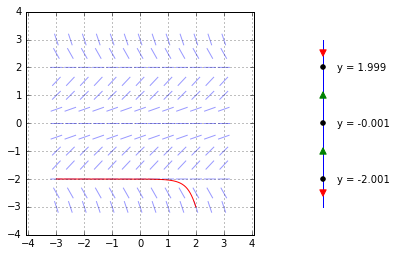

In [40]:
plot_ode_solution(f2, ic=(2,-3), c=None,
    slope_field_step=(.5,.5), t_lim=(-3,3), y_lim=(-3,3))

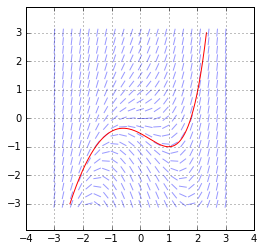

In [41]:
plot_ode_solution(f1, ic=(1,-1), c=None,
    slope_field_step=(.3,.3), t_lim=(-3,3), y_lim=(-3,3))

/usr/local/lib/python3.4/dist-packages/scipy/integrate/odepack.py:156: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


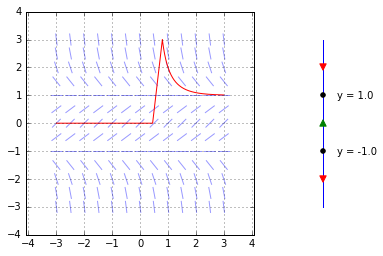

In [42]:
plot_ode_solution(f3, ic=(1,2), c=1,
    slope_field_step=(.5,.5), t_lim=(-3,3), y_lim=(-3,3), t_del=1e-3)

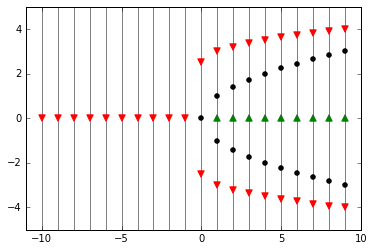

In [43]:
plot_parameterized_phase_lines(f3, range(-10,10), (-5,5))